# Notebook to Start Pulling it All Together

## Salinity 5 m and deeper  
Now with removing bad data.

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import netCDF4 as nc
import numpy as np
import pandas as pd
import statsmodels.api as sm

from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [3]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [4]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [5]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [6]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [7]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [8]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [9]:
def filter_bad_data(temp1):
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
    temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
    return temp1_nobox_nohook

In [10]:
def plot_and_stats(temp1, name):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 36
    vmin = 12
    counts, xedges, yedges, color = ax.hist2d(temp1.SA[temp1.k >= 5], temp1.mod_vosaline[temp1.k >= 5], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    trmse = rmse(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    tswillmott = swillmott(temp1[temp1.k >=5], 'SA', 'mod_vosaline')
    m, c, syst, nonsyst = slope_inter(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    tspread = spread(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    ax.plot(np.arange(vmin, vmax, 0.5), c + m*np.arange(vmin, vmax, 0.5), 'r-');
    ax.arrow(13, 31, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(13, 33, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 31, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 33, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 31, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 33, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(13-0.2, 26, 'bias', rotation=90)
    ax.text(14-0.2, 25, 'systematic', rotation=90)
    ax.text(15-0.2, 24, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Salinity below 5 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [11]:
pieces = ('/home/sallen/202007/H201812/ObsModel_H201812_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_onc_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_onc_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_onc_20170101_20171231.csv'
         )

<ipython-input-9-75e9c381a395>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1294941,0.12,0.4,0.037,0.08,2.5,0.15,0.37,0.031


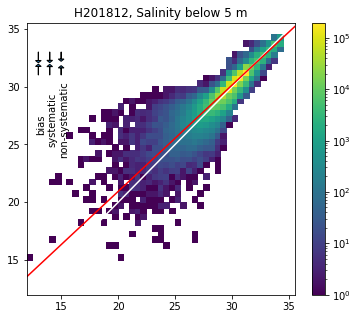

In [12]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
d201812 = plot_and_stats(filter_bad_data(temp1), 'H201812')
d201812.style.format(myformat)

In [13]:
pieces = (
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150101_20150331.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150301_20150630.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150601_20150930.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150901_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20160101_20161231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20170101_20171231.csv'
         )

<ipython-input-9-75e9c381a395>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,1294941,0.11,0.4,0.036,0.07,2.2,0.13,0.37,0.01


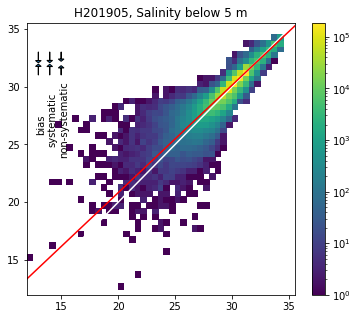

In [14]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
d201905 = plot_and_stats(filter_bad_data(temp1), 'H201905')
d201905.style.format(myformat)

## 2017 only

<ipython-input-101-75e9c381a395>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,384995,0.15,0.4,0.034,0.065,2.1,0.16,0.37,0.018


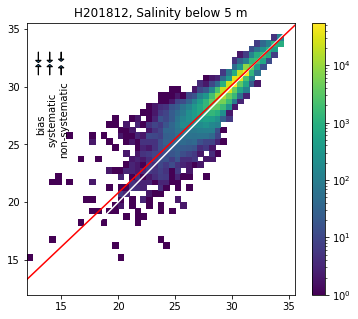

In [113]:
ntemp = filter_bad_data(temp1)
ntemp.set_index('dtUTC', inplace=True)
ntemp.sort_index(inplace=True)
ntemp.index = pd.to_datetime(ntemp.index)
d201812 = plot_and_stats(ntemp[ntemp.index > dt.datetime(2017, 1, 1)], 'H201812')
d201812.style.format(myformat)

<ipython-input-101-75e9c381a395>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,384995,0.17,0.41,0.035,0.063,2.1,0.18,0.37,0.013


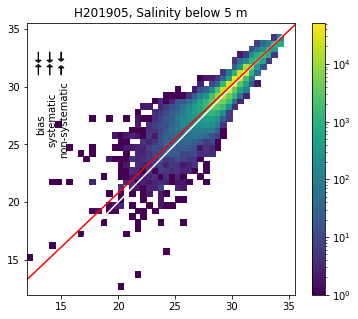

In [116]:
ntemp = filter_bad_data(temp1)
ntemp.set_index('dtUTC', inplace=True)
ntemp.sort_index(inplace=True)
ntemp.index = pd.to_datetime(ntemp.index)
d201905 = plot_and_stats(ntemp[ntemp.index > dt.datetime(2017, 1, 1)], 'H201905')
d201905.style.format(myformat)

## SSH difference North to West ##
Change in along strait pressure is the major difference between 201812 and 201905.  We have gone back to 201812 (9.8 cm).
Analysis over the whole time period shows 201905 is better but the initial conditions for these runs is not the same.
If we look just at 2017, after the initial conditions have had time to disappear (201812 was started in 2015), we see drift to higher salinity bias but this drift is less in 201812, slightly supporting the higher pressure difference.

### Back to All Years

In [15]:
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170101-20170331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170401-20170630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170701-20170930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20171001-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_onc_20150101_20151231.csv',
        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_onc_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_onc_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20170101_20171231.csv'
         )

<ipython-input-9-75e9c381a395>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp2,1294276,0.099,0.4,0.036,0.074,2.3,0.13,0.37,0.018


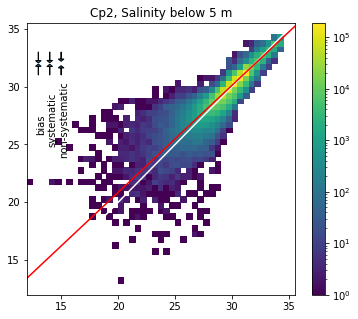

In [16]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
dCp2 = plot_and_stats(filter_bad_data(temp1), 'Cp2')
dCp2.style.format(myformat)

In [17]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150101-20150331.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150401-20150630.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150701-20150930.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20151001-20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_onc_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_onc_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_onc_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20170101_20171231.csv'
        )

<ipython-input-9-75e9c381a395>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Dagain,1290386,0.099,0.4,0.036,0.071,2.3,0.13,0.37,0.012


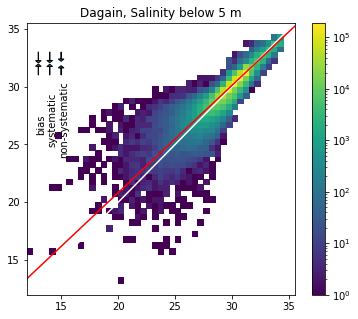

In [18]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
Dagain = plot_and_stats(filter_bad_data(temp1), 'Dagain')
Dagain.style.format(myformat)

In [19]:
pieces = ('/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_onc_20150101_20151231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_onc_20160101_20161231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_onc_20170101_20171231.csv'
        )

<ipython-input-9-75e9c381a395>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-noCil,1294941,0.098,0.4,0.036,0.072,2.3,0.12,0.38,0.013


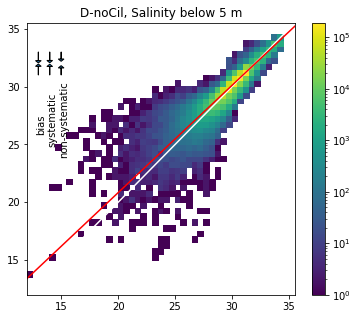

In [20]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
DnoC = plot_and_stats(filter_bad_data(temp1), 'D-noCil')
DnoC.style.format(myformat)

In [21]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_onc_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_onc_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_onc_20170101_20171231.csv'
         )

<ipython-input-9-75e9c381a395>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-lowR,1294941,0.098,0.4,0.036,0.071,2.2,0.12,0.38,0.011


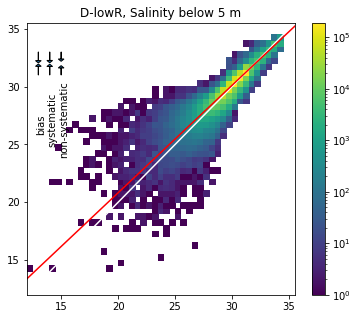

In [22]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
DlowR = plot_and_stats(filter_bad_data(temp1), 'D-lowR')
DlowR.style.format(myformat)

In [32]:
pieces = (#'/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TS_20150101-20150331.csv',
         #'/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TS_20150401-20150630.csv',
         #'/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TS_20150701-20150930.csv',
         #'/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TS_20151001-20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20160101_20161231.csv',
          '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TSPUG_20150101-20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20160101_20161231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20160101_20161231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_onc_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_onc_20160101_20161231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_onc_20170101_20171231.csv')

<ipython-input-9-75e9c381a395>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp3,1164744,0.11,0.38,0.033,0.059,1.9,0.13,0.36,-0.00069


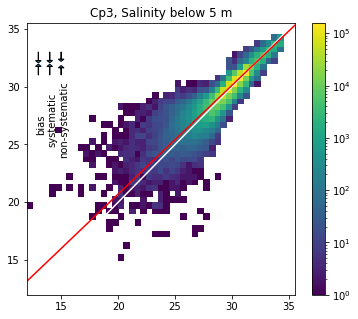

In [33]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modCp3 = plot_and_stats(filter_bad_data(temp1), 'Cp3')
modCp3.style.format(myformat)

In [36]:
pieces = (#'/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20170101_20171231.csv'
         )

<ipython-input-9-75e9c381a395>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,1164744,0.095,0.38,0.032,0.051,1.6,0.11,0.36,-0.018


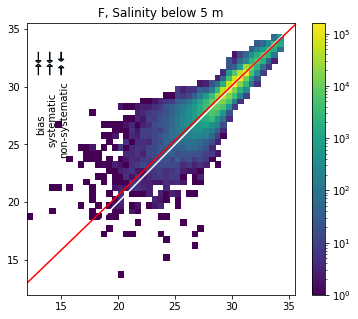

In [37]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modF = plot_and_stats(filter_bad_data(temp1), 'F')
modF.style.format(myformat)

In [27]:
def highlight_max_min(s):
    '''
    highlight the minimum/maximum in a Series.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [31]:
alltogether = pd.concat([d201812,d201905, dCp2, Dagain, DnoC, DlowR, modCp3, modF], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1294941,0.12,0.4,0.037,0.08,2.5,0.15,0.37,0.031
H201905,1294941,0.11,0.4,0.036,0.07,2.2,0.13,0.37,0.01
Cp2,1294276,0.099,0.4,0.036,0.074,2.3,0.13,0.37,0.018
Dagain,1290386,0.099,0.4,0.036,0.071,2.3,0.13,0.37,0.012
D-noCil,1294941,0.098,0.4,0.036,0.072,2.3,0.12,0.38,0.013
D-lowR,1294941,0.098,0.4,0.036,0.071,2.2,0.12,0.38,0.011
Cp3,1290386,0.11,0.37,0.032,0.06,1.9,0.12,0.35,0.0066
F,1294941,0.092,0.37,0.031,0.052,1.7,0.11,0.35,-0.0097


## Below this line: all is original before removing bad data

In [92]:
alltogether = pd.concat([d201812,d201905, dCp2, Dagain, DnoC, DlowR, modF], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1312447,0.15,0.5,0.056,0.13,4.1,0.21,0.45,0.07
H201905,1312447,0.14,0.5,0.055,0.12,3.8,0.19,0.46,0.049
Cp2,1311782,0.13,0.49,0.055,0.13,3.9,0.19,0.46,0.057
Dagain,1307892,0.13,0.49,0.055,0.12,3.9,0.19,0.46,0.052
D-noCil,1312447,0.13,0.49,0.055,0.12,3.8,0.19,0.46,0.052
D-lowR,1312447,0.13,0.49,0.055,0.12,3.8,0.19,0.46,0.05
F,1312447,0.12,0.47,0.05,0.1,3.3,0.17,0.44,0.03


## The Hook ##

Note the hook at obs=22, model=30 : what is this?

In [139]:
temp1.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Z', 'SA', 'CT', 'Fluor',
       'dtUTC', 'j', 'i', 'mod_nitrate', 'mod_silicon', 'mod_ammonium',
       'mod_diatoms', 'mod_ciliates', 'mod_flagellates', 'mod_vosaline',
       'mod_votemper', 'k', 'Station', 'Basin', 'Sigma', 'Chl', 'SiteCode',
       'station', 'ID', 'Patrol', 'pressure', 'chl', 'o2SAT', 'o2uM',
       'conductivity', 'temperature', 'time (UTC)',
       'temperature (degrees_Celcius)', 'salinity (g/kg)', 'depth (m)',
       'conservative temperature (oC)'],
      dtype='object')

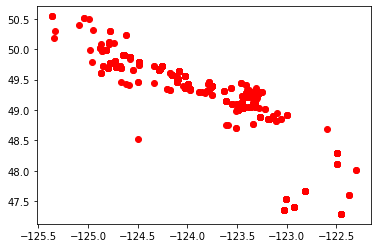

In [143]:
plt.plot(temp1.Lon[(temp1.SA < 25) & (temp1.mod_vosaline >27)],
         temp1.Lat[(temp1.SA < 25) & (temp1.mod_vosaline >27)], 'ro');

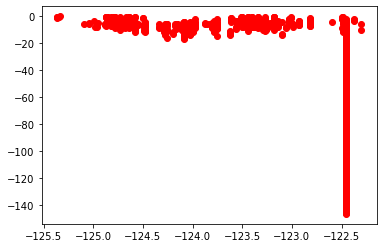

In [142]:
plt.plot(temp1.Lon[(temp1.SA < 25) & (temp1.mod_vosaline >27)],
         -temp1.Z[(temp1.SA < 25) & (temp1.mod_vosaline >27)], 'ro');

In [144]:
print (temp1[(temp1.SA < 25) & (temp1.mod_vosaline > 27) & (temp1.Z > 20)])

        Year  Month  Day  Hour        Lat         Lon      Z         SA  \
560149   NaN    NaN  NaN   NaN  47.290377 -122.450123   20.5  22.783711   
560150   NaN    NaN  NaN   NaN  47.290377 -122.450123   21.0  22.769528   
560151   NaN    NaN  NaN   NaN  47.290377 -122.450123   21.5  22.758762   
560152   NaN    NaN  NaN   NaN  47.290377 -122.450123   22.0  22.746187   
560153   NaN    NaN  NaN   NaN  47.290377 -122.450123   22.5  22.735723   
...      ...    ...  ...   ...        ...         ...    ...        ...   
560397   NaN    NaN  NaN   NaN  47.290377 -122.450123  144.5  21.410255   
560398   NaN    NaN  NaN   NaN  47.290377 -122.450123  145.0  21.412575   
560399   NaN    NaN  NaN   NaN  47.290377 -122.450123  145.5  21.415698   
560400   NaN    NaN  NaN   NaN  47.290377 -122.450123  146.0  21.419224   
560401   NaN    NaN  NaN   NaN  47.290377 -122.450123  146.5  21.419534   

               CT  Fluor  ... chl  o2SAT  o2uM  conductivity  temperature  \
560149  10.854616    N

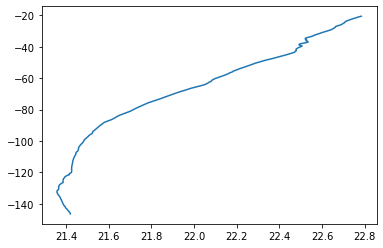

In [148]:
plt.plot(temp1.SA[(temp1.SA < 25) & (temp1.mod_vosaline > 27) & (temp1.Z > 20)],
 -temp1.Z[(temp1.SA < 25) & (temp1.mod_vosaline > 27) & (temp1.Z > 20)])

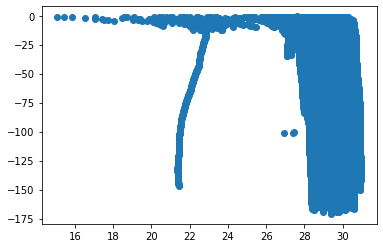

In [150]:
plt.plot(temp1.SA[temp1.Lat < 47.30], 
 -temp1.Z[temp1.Lat < 47.30], 'o')

/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


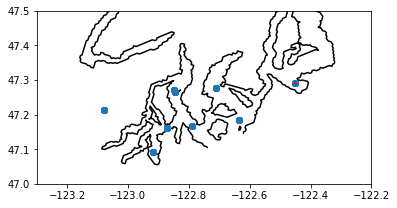

In [162]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
grid = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(47, 47.5)
#ax.legend()
ax.set_xlim(-123.3, -122.2);

ax.plot(temp1.Lon[temp1.Lat < 47.30], 
 temp1.Lat[temp1.Lat < 47.30], 'o');

ax.plot(-122.450123, 47.290377,'r+');

(-20.0, 0.0)

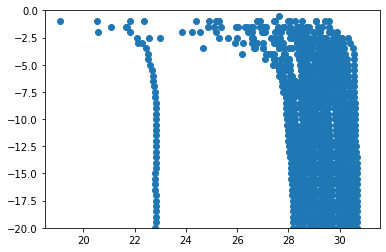

In [166]:
plt.plot(temp1.SA[(temp1.Lat < 47.30) & (temp1.Lon > -122.5)], 
 -temp1.Z[(temp1.Lat < 47.30) & (temp1.Lon > -122.5)], 'o')
plt.ylim(-20, 0)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,1312164,0.12,0.46,0.047,0.094,3.0,0.16,0.43,0.018


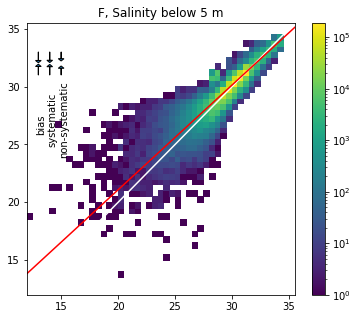

In [168]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modF = plot_and_stats(temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26)], 'F')
modF.style.format(myformat)

## The Hook

Is due to a single bad profile in Tacoma Harbor.  Removing it, removes the hook and decreases the rmse, the sWillmott, the slopedev, the const, the systematic and non-systematic error and the spread deviation.

## The Box

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,16779,2.4,2.4,0.91,0.11,5.5,2.4,0.19,-1.3


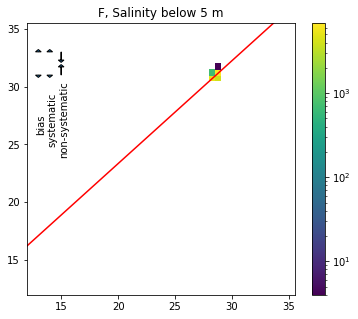

In [13]:
modF = plot_and_stats(temp1[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'F')
modF.style.format(myformat)

/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


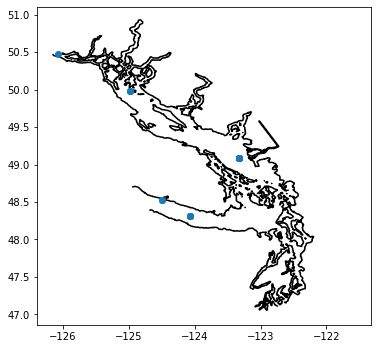

In [14]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
grid = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')

ax.plot(temp1.Lon[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 
 temp1.Lat[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'o');


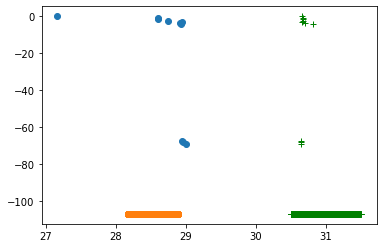

In [19]:
plt.plot(temp1.SA[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 
 -temp1.Z[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'o')
plt.plot(temp1.mod_vosaline[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 
 -temp1.Z[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'g+')
plt.plot(temp1.SA[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 
 -temp1['depth (m)'][(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'o')
plt.plot(temp1.mod_vosaline[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 
 -temp1['depth (m)'][(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'g+')

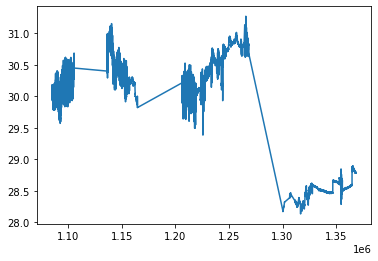

In [28]:
plt.plot(temp1.SA[temp1['depth (m)'] == 107])

According to ONC, all 2017 (that lower data) failed QC.

<ipython-input-32-51cdbfe48337>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,1294941,0.092,0.37,0.031,0.052,1.7,0.11,0.35,-0.0097


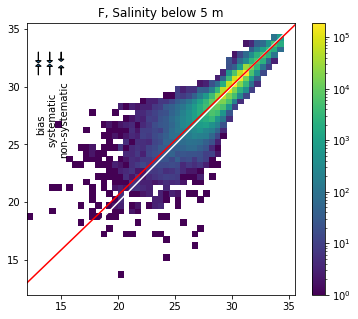

In [32]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
modF = plot_and_stats(temp1_nobox_nohook, 'F')
modF.style.format(myformat)

In [34]:
## Without Puget Sound

In [66]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
       #  '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
       #  '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20170101_20171231.csv'
         )

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,1155080,0.11,0.35,0.029,0.066,2.1,0.13,0.33,0.03


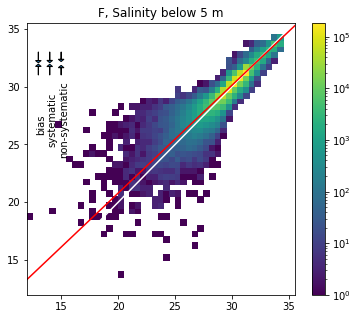

In [67]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
modF = plot_and_stats(temp1_nobox_nohook, 'F')
modF.style.format(myformat)

/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


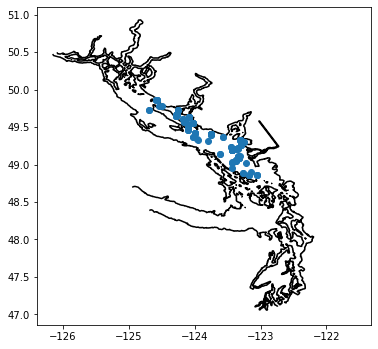

In [68]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
viz_tools.plot_coastline(ax, grid, coords = 'map')

ax.plot(temp1.Lon[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >= 5)], 
 temp1.Lat[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >= 5)], 'o');


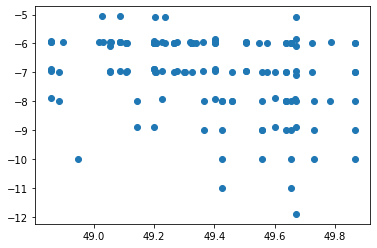

In [69]:
plt.plot(temp1.Lat[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 
 -temp1.Z[(temp1.mod_vosaline > 25) & (temp1.SA < 23)& (temp1.k >=5)], 'o');
plt.plot(temp1.Lat[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 
 -temp1['depth (m)'][(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 'o');

This region of the distribution is reflecting too high salinity in the model in the halocline of the SoG.

/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


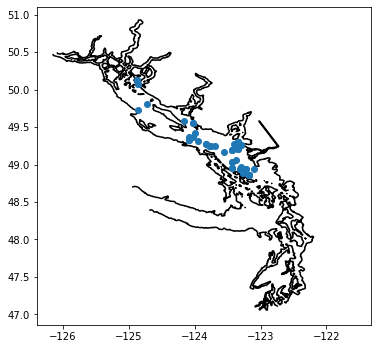

In [70]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
viz_tools.plot_coastline(ax, grid, coords = 'map')

ax.plot(temp1.Lon[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >= 5)], 
 temp1.Lat[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >= 5)], 'o');

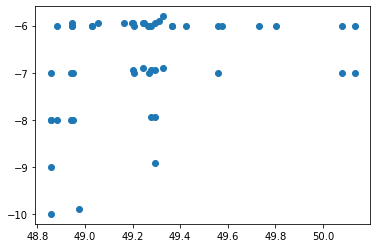

In [71]:
plt.plot(temp1.Lat[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 
 -temp1.Z[(temp1.mod_vosaline < 23) & (temp1.SA > 25)& (temp1.k >=5)], 'o');
plt.plot(temp1.Lat[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 
 -temp1['depth (m)'][(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 'o');

More limited cases when the model is too fresh compared to the obs.  Note that this most often occurs on the west side, whereas the high salinities are on the east side.

In [72]:
temp1['dtUTC'] = pd.to_datetime(temp1.dtUTC)

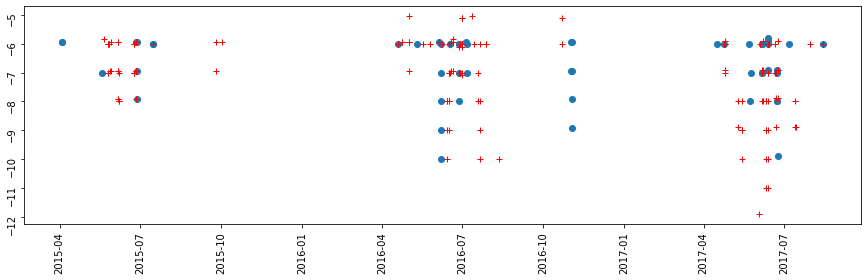

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(temp1.dtUTC[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 
 -temp1.Z[(temp1.mod_vosaline < 23) & (temp1.SA > 25)& (temp1.k >=5)], 'o');
ax.plot(temp1.dtUTC[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 
 -temp1['depth (m)'][(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 'o');
ax.plot(temp1.dtUTC[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 
 -temp1.Z[(temp1.mod_vosaline > 25) & (temp1.SA < 23)& (temp1.k >=5)], 'r+');
ax.plot(temp1.dtUTC[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 
 -temp1['depth (m)'][(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 'r+');
ax.tick_params(labelrotation=90)

In [74]:
temp2017 = temp1[temp1.dtUTC > dt.datetime(2017, 1, 1)]

/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


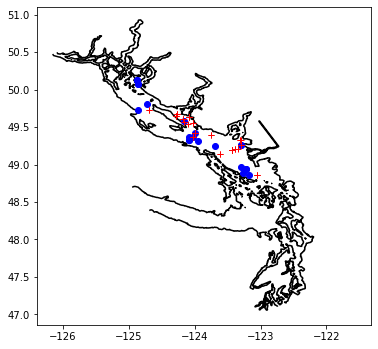

In [75]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.plot(temp2017.Lon[(temp2017.mod_vosaline < 23) & (temp2017.SA > 25) & (temp2017.k >=5)], 
 temp2017.Lat[(temp2017.mod_vosaline < 23) & (temp2017.SA > 25)& (temp2017.k >=5)], 'bo');
ax.plot(temp2017.Lon[(temp2017.mod_vosaline > 25) & (temp2017.SA < 23) & (temp2017.k >=5)], 
 temp2017.Lat[(temp2017.mod_vosaline > 25) & (temp2017.SA < 23)& (temp2017.k >=5)], 'r+');

Looking just at 2017 case, it is clear that the east side is too salt in the model and the west side is too fresh.  Suggesting that the cross-strait tilt of the isohalines is not strong enough.